In [280]:
import pandas as pd
df = pd.read_csv("wage.csv")

In [281]:
df

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154
...,...,...,...,...,...,...,...,...,...,...,...
2995,2008,44,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,2. >=Very Good,1. Yes,5.041393,154.685293
2996,2007,30,2. Married,1. White,2. HS Grad,2. Middle Atlantic,1. Industrial,2. >=Very Good,2. No,4.602060,99.689464
2997,2005,27,2. Married,2. Black,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.193125,66.229408
2998,2005,27,1. Never Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,2. >=Very Good,1. Yes,4.477121,87.981033


In [282]:
df = df.drop(columns='region')
df.rename(columns={'maritl':'marital_status'})
df.describe()

,year,age,logwage,wage
count,3000.000000,3000.000000,3000.000000,3000.000000
mean,2005.791000,42.414667,4.653905,111.703608
std,2.026167,11.542406,0.351753,41.728595
min,2003.000000,18.000000,3.000000,20.085537
25%,2004.000000,33.750000,4.447158,85.383940
50%,2006.000000,42.000000,4.653213,104.921507
75%,2008.000000,51.000000,4.857332,128.680488
max,2009.000000,80.000000,5.763128,318.342430


In [283]:
df.isna().sum().sum()

0

In [284]:
df[['year', 'wage']].corr()

,year,wage
year,1.000000,0.065544
wage,0.065544,1.000000


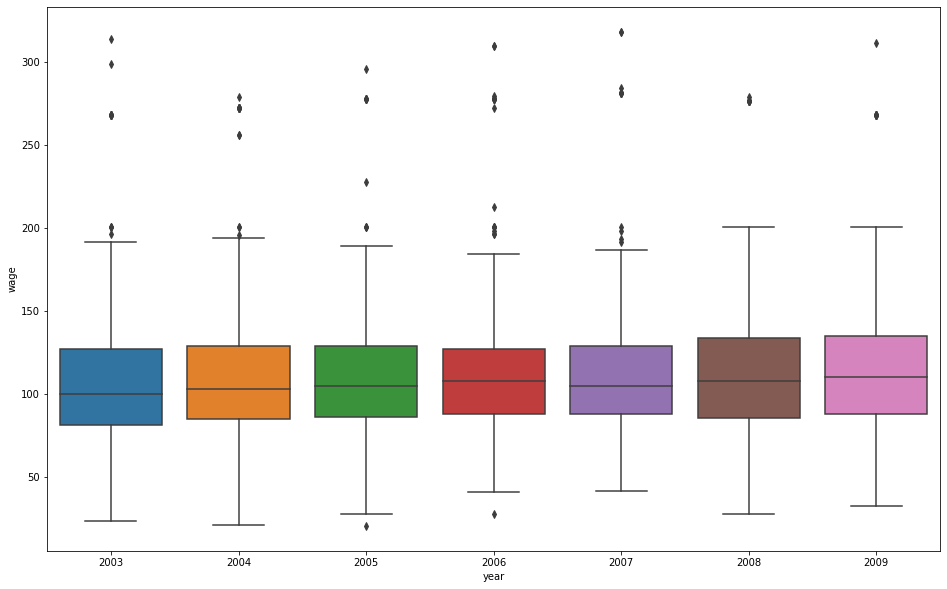

In [285]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(16, 10));
sns.boxplot(x='year', y='wage', data=df[['year', 'wage']]);

In [286]:
df = df.drop(columns='year')

In [287]:
#df_cat = df.select_dtypes('object')
df_cat = df.drop(columns=['age', 'logwage', 'wage'])

In [288]:
df_cat

,maritl,race,education,jobclass,health,health_ins
0,1. Never Married,1. White,1. < HS Grad,1. Industrial,1. <=Good,2. No
1,1. Never Married,1. White,4. College Grad,2. Information,2. >=Very Good,2. No
2,2. Married,1. White,3. Some College,1. Industrial,1. <=Good,1. Yes
3,2. Married,3. Asian,4. College Grad,2. Information,2. >=Very Good,1. Yes
4,4. Divorced,1. White,2. HS Grad,2. Information,1. <=Good,1. Yes
...,...,...,...,...,...,...
2995,2. Married,1. White,3. Some College,1. Industrial,2. >=Very Good,1. Yes
2996,2. Married,1. White,2. HS Grad,1. Industrial,2. >=Very Good,2. No
2997,2. Married,2. Black,1. < HS Grad,1. Industrial,1. <=Good,2. No
2998,1. Never Married,1. White,3. Some College,1. Industrial,2. >=Very Good,1. Yes


In [289]:
category_counts=list(map(lambda col: df[col].value_counts(), df_cat.columns))
for category in category_counts:
    print(category, "\n")

2. Married          2074
1. Never Married     648
4. Divorced          204
5. Separated          55
3. Widowed            19
Name: maritl, dtype: int64 

1. White    2480
2. Black     293
3. Asian     190
4. Other      37
Name: race, dtype: int64 

2. HS Grad            971
4. College Grad       685
3. Some College       650
5. Advanced Degree    426
1. < HS Grad          268
Name: education, dtype: int64 

1. Industrial     1544
2. Information    1456
Name: jobclass, dtype: int64 

2. >=Very Good    2142
1. <=Good          858
Name: health, dtype: int64 

1. Yes    2083
2. No      917
Name: health_ins, dtype: int64 



In [290]:
df_cat = df_cat.applymap(lambda x: x[3:])

In [291]:
df_cat

,maritl,race,education,jobclass,health,health_ins
0,Never Married,White,< HS Grad,Industrial,<=Good,No
1,Never Married,White,College Grad,Information,>=Very Good,No
2,Married,White,Some College,Industrial,<=Good,Yes
3,Married,Asian,College Grad,Information,>=Very Good,Yes
4,Divorced,White,HS Grad,Information,<=Good,Yes
...,...,...,...,...,...,...
2995,Married,White,Some College,Industrial,>=Very Good,Yes
2996,Married,White,HS Grad,Industrial,>=Very Good,No
2997,Married,Black,< HS Grad,Industrial,<=Good,No
2998,Never Married,White,Some College,Industrial,>=Very Good,Yes


In [292]:
from scipy.stats import chi2_contingency

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [293]:
import numpy as np

rows = []

for var1 in df_cat.columns:
    col = []
    for var2 in df_cat.columns :
        col.append(round(cramers_v(df_cat[var1], df_cat[var2]),2))
    rows.append(col)

cramer_matrix = pd.DataFrame(np.array(rows), columns = df_cat.columns, index = df_cat.columns)

In [294]:
cramer_matrix

,maritl,race,education,jobclass,health,health_ins
maritl,1.00,0.07,0.06,0.02,0.05,0.09
race,0.07,1.00,0.12,0.09,0.03,0.03
education,0.06,0.12,1.00,0.30,0.17,0.21
jobclass,0.02,0.09,0.30,1.00,0.06,0.15
health,0.05,0.03,0.17,0.06,1.00,0.07
health_ins,0.09,0.03,0.21,0.15,0.07,1.00


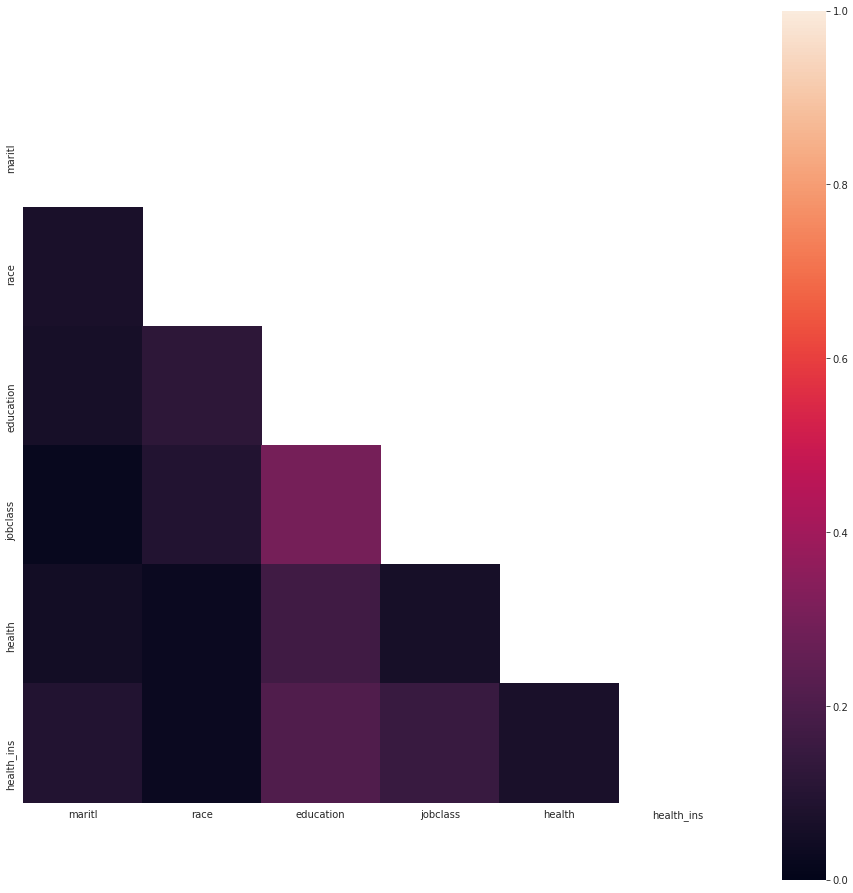

In [295]:
mask = np.zeros_like(cramer_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(16, 16))
    ax = sns.heatmap(cramer_matrix, mask=mask, vmin=0., vmax=1, square=True)

In [296]:
df_cat

,maritl,race,education,jobclass,health,health_ins
0,Never Married,White,< HS Grad,Industrial,<=Good,No
1,Never Married,White,College Grad,Information,>=Very Good,No
2,Married,White,Some College,Industrial,<=Good,Yes
3,Married,Asian,College Grad,Information,>=Very Good,Yes
4,Divorced,White,HS Grad,Information,<=Good,Yes
...,...,...,...,...,...,...
2995,Married,White,Some College,Industrial,>=Very Good,Yes
2996,Married,White,HS Grad,Industrial,>=Very Good,No
2997,Married,Black,< HS Grad,Industrial,<=Good,No
2998,Never Married,White,Some College,Industrial,>=Very Good,Yes


In [297]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(drop=['Widowed', 'Other', '< HS Grad', 'Information', '<=Good', 'No'], sparse=False).fit(df_cat)

In [298]:
col_names = enc.get_feature_names(df_cat.columns)

In [299]:
df_cat_ohe = pd.DataFrame(enc.transform(df_cat), columns=col_names)

In [300]:
df_tidy=pd.concat([df_cat_ohe, df[['age', 'wage']]], axis = 1)

In [301]:
df_tidy

,maritl_Divorced,maritl_Married,maritl_Never Married,maritl_Separated,race_Asian,race_Black,race_White,education_Advanced Degree,education_College Grad,education_HS Grad,education_Some College,jobclass_Industrial,health_>=Very Good,health_ins_Yes,age,wage
0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,18,75.043154
1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,24,70.476020
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,45,130.982177
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,43,154.685293
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,50,75.043154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,44,154.685293
2996,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,30,99.689464
2997,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,27,66.229408
2998,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,27,87.981033


In [302]:
from sklearn.model_selection import train_test_split

x, y = df_tidy.drop(columns='wage'), df_tidy['wage']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [303]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

rf_parameters = {
    'n_estimators': [100, 250, 500, 1000, 1500, 2000],
    'min_samples_split': [2, 10, 30, 50, 75],
    'max_features': [1, 2, 3, 4, 8, 11, 15]
}

rf_gridsearch = GridSearchCV(
    estimator = RandomForestRegressor(random_state=42),
    param_grid=rf_parameters,
    cv=5,
    n_jobs=2,
    scoring='neg_mean_squared_error',
    verbose=1
)

In [304]:
rf_gridsearch.fit(x_train, y_train)

Fitting 5 folds for each of 210 candidates, totalling 1050 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
/home/nguaphap/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   54.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  3.9min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  8.7min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed: 16.7min
[Parallel(n_jobs=2)]: Done 1050 out of 1050 | elapsed: 24.1min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

In [305]:
rf_gridsearch.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=4, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=75, min_weight_fraction_leaf=0.0,
                      n_estimators=250, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [306]:
(-rf_gridsearch.score(x_test, y_test))**(1/2)

30.880277276182852

In [278]:
x_test

,maritl_Divorced,maritl_Married,maritl_Never Married,maritl_Separated,race_Asian,race_Black,race_White,education_Advanced Degree,education_College Grad,education_HS Grad,education_Some College,jobclass_Industrial,health_>=Very Good,health_ins_Yes,age
1801,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,46
1190,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,25
1817,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,36
251,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,47
2505,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,50
2087,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,45
599,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,18
1756,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,52
